# Hyperparameter Optimization for Stance Classification (OPTUNA)

The goal of this notebook is to optimize the Binary F1-score of a stance classification model using hyperparameter optimization (HPO) techniques with Optuna.
We fine-tune our winner model (Best Performance) on a balanced dataset (Previously Augmented) of tweets labeled as support or oppose.

We incorporate:
- Bayesian Optimization (TPE Sampler) to efficiently explore the hyperparameter space.
- Early Stopping to prevent overfitting by stopping training.
- Pruning (Median Pruner) to terminate unpromising trials early and save GPU time.
- Evaluation Metrics: Accuracy, Precision, Recall, and F1-score (Binary).

In [4]:
# Libraries
import os
import re
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
import ast
import matplotlib.pyplot as plt
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import warnings
import json
warnings.filterwarnings('ignore')

# Google Colab or not
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data from Google Drive: {path}")
else:
    path = "/workspace/dzuniga/"
    os.chdir(path)
    print(f"Loading data locally from: {path}")


# GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU ready:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU detecting, using CPU.")

#If we use the augmented dataset:
augmented = True

# Set Seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Loading data locally from: /workspace/dzuniga/
GPU ready: NVIDIA H100 NVL


In [5]:
# Load Dataset
if augmented:
  train_path = f"{path}/data/train_augmented_synonym.csv"
else:
  train_path = f"{path}/data/train.csv"

dev_path   = f"{path}/data/dev.csv"
test_path  = f"{path}/data/test.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)


# Map labels to ints
label2id = {"oppose": 0, "support": 1}

#Minimal Preprocessing
def clean_tweet(text):

    text = str(text)
    #URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    return text


for df in [df_train, df_dev, df_test]:
    #df["tweet_text"] = df["tweet_text"].apply(clean_tweet) Based on our experiment we remove any cleaning to keep the original tweet
    df["label"] = df["stance"].map(label2id)


dataset_train = Dataset.from_pandas(df_train[["tweet_text","label"]])
dataset_dev   = Dataset.from_pandas(df_dev[["tweet_text","label"]])
dataset_test  = Dataset.from_pandas(df_test[["tweet_text","label"]])

In [6]:
# We define our Model
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LEN=105

In [7]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
print(f"Tokenizer loaded: {MODEL_NAME}")


# Tokenization Function for each model
def tokenize_dataset(dataset, tokenizer, max_length=MAX_LEN):

    def tokenize_batch(batch):
        return tokenizer(batch["tweet_text"],padding="max_length",truncation=True,max_length=max_length)

    #Tokenization
    tokenized = dataset.map(tokenize_batch, batched=True)

    #Dataset Format for PyTorch
    tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    return tokenized

# Tokenize datasets with model tokenizer
train_dataset_tok = tokenize_dataset(dataset_train, tokenizer, MAX_LEN)
dev_dataset_tok = tokenize_dataset(dataset_dev, tokenizer, MAX_LEN)
test_dataset_tok = tokenize_dataset(dataset_test, tokenizer, MAX_LEN)

print(f"Tokenization complete")

Tokenizer loaded: microsoft/deberta-v3-base


Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenization complete


In [8]:
#Metrics we are going to evaluate
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="binary", pos_label=1)
    precision = precision_score(labels, preds, average="binary", pos_label=1)
    recall = recall_score(labels, preds, average="binary", pos_label=1)
    
    return {"accuracy": acc,"f1": f1,"precision": precision,"recall": recall}


### Hyperparameter Optimization - OPTUNA

In [9]:
BASELINE_CONFIG = {
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "batch_size": 16,
    "num_train_epochs": 5,
    "warmup_ratio": 0.0,
    "dropout": 0.1}

print("Baseline Config:")
for key, value in BASELINE_CONFIG.items():
    print(f"{key}: {value}")

Baseline Config:
learning_rate: 2e-05
weight_decay: 0.01
batch_size: 16
num_train_epochs: 5
warmup_ratio: 0.0
dropout: 0.1


In [10]:
# We are facing overfitting using only the dev dataset for validation, we are now applying stratification in our train dataset.
train_labels = [ex['label'] for ex in train_dataset_tok]
train_idx, val_idx = train_test_split(range(len(train_dataset_tok)),test_size=0.2,stratify=train_labels,random_state=seed)

#Tokenize
train_subset = train_dataset_tok.select(train_idx)
val_subset = train_dataset_tok.select(val_idx)

print(f"Train subset: {len(train_subset)}, Val subset: {len(val_subset)}")
print(f"Dev set: {len(dev_dataset_tok)}")

Train subset: 1752, Val subset: 438
Dev set: 200


In [11]:
# Objective Function for Hyperparameter Optimization (OPTUNA) - F1 Score (Binary)
def objective(trial):

    #Hyperparameters to optimize

    # Our search space
    if trial.number > 0:
        learning_rate = trial.suggest_float("learning_rate", 8e-6, 4e-5, log=True)
        weight_decay = trial.suggest_float("weight_decay",0.01, 0.15)
        per_device_train_batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
        num_train_epochs = trial.suggest_int("num_train_epochs", 3, 6)
        warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.15)
        dropout = trial.suggest_float("dropout", 0.1, 0.25)
    else:
        # First trial: Use BASELINE configuration (Performance Benchmark and Data Augmentation notebooks)
        print(f"\n Trial {trial.number}: Using BASELINE configuration")
        learning_rate = BASELINE_CONFIG["learning_rate"]
        weight_decay = BASELINE_CONFIG["weight_decay"]
        per_device_train_batch_size = BASELINE_CONFIG["batch_size"]
        num_train_epochs = BASELINE_CONFIG["num_train_epochs"]
        warmup_ratio = BASELINE_CONFIG["warmup_ratio"]
        dropout = BASELINE_CONFIG["dropout"]


    print(f"\nTrial {trial.number} hyperparameters:")
    print(f"  LR: {learning_rate:.2e}, Batch: {per_device_train_batch_size}, "
          f"Epochs: {num_train_epochs}, WD: {weight_decay:.3f}, "
          f"Warmup: {warmup_ratio:.2f}, Dropout: {dropout:.2f}")

    f1_score = train_single_trial(
        trial=trial,
        train_dataset=train_subset, 
        eval_dataset=val_subset,     
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        warmup_ratio=warmup_ratio,
        dropout=dropout,
        seed=seed
    )

    return f1_score

def train_single_trial(trial, train_dataset, eval_dataset, learning_rate, weight_decay,
                      per_device_train_batch_size, num_train_epochs, warmup_ratio, dropout, seed):


    # Set seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Load Model for this trial
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                               num_labels=2,
                                                               hidden_dropout_prob=dropout,
                                                               attention_probs_dropout_prob=dropout).to(device)

    # Training Arguments
    training_args = TrainingArguments(
        output_dir=f"./optuna-trial-{trial.number}-seed{seed}",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=1,
        report_to="none",
        logging_steps=10,
        seed=seed,  # Reproducibility
        data_seed=seed,  # Reproducibility
    )

    # Trainer with Early Stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train
    trainer.train()

    # Final evaluation on dev set
    final_metrics = trainer.evaluate(eval_dataset)
    f1 = final_metrics["eval_f1"]

    print(f"  Trial {trial.number} (seed {seed}) - F1(Binary): {f1:.4f}")

    # Cleanup to save memory
    del model
    del trainer
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return f1

We use **TPESampler** because it efficiently explores the hyperparameter space by learning from previous trials. Unlike random search, it focuses on promising regions, increasing the chances of finding optimal hyperparameters faster and with fewer trials. It is especially useful for mixed spaces with continuous, integer, and categorical parameters.

In [12]:
print("STARTING HYPERPARAMETER OPTIMIZATION")

study = optuna.create_study(direction="maximize",
                            sampler=TPESampler(seed=seed),
                            pruner=MedianPruner(n_warmup_steps=2, n_startup_trials=3))


trails = 20
study.optimize(objective, n_trials=trails, timeout=None)

[I 2025-11-12 15:39:17,443] A new study created in memory with name: no-name-5ffc7800-407c-41d6-b4eb-6dc570ca31e1


STARTING HYPERPARAMETER OPTIMIZATION

 Trial 0: Using BASELINE configuration

Trial 0 hyperparameters:
  LR: 2.00e-05, Batch: 16, Epochs: 5, WD: 0.010, Warmup: 0.00, Dropout: 0.10


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.452600,0.328388,0.876712,0.885106,0.828685,0.949772
2,0.190200,0.258578,0.906393,0.903529,0.932039,0.876712
3,0.090300,0.380243,0.913242,0.914798,0.898678,0.931507
4,0.034000,0.403497,0.913242,0.913242,0.913242,0.913242
5,0.016500,0.415441,0.913242,0.912844,0.917051,0.908676


[I 2025-11-12 15:40:05,313] Trial 0 finished with value: 0.9147982062780269 and parameters: {}. Best is trial 0 with value: 0.9147982062780269.


  Trial 0 (seed 42) - F1(Binary): 0.9148

Trial 1 hyperparameters:
  LR: 1.46e-05, Batch: 8, Epochs: 3, WD: 0.143, Warmup: 0.01, Dropout: 0.23


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.603700,0.476724,0.773973,0.714697,0.968750,0.566210
2,0.390500,0.441048,0.842466,0.816976,0.974684,0.703196
3,0.305200,0.394184,0.874429,0.857143,0.993976,0.753425


[I 2025-11-12 15:40:44,026] Trial 1 finished with value: 0.8571428571428571 and parameters: {'learning_rate': 1.4617809420852987e-05, 'weight_decay': 0.14310000289738825, 'batch_size': 8, 'num_train_epochs': 3, 'warmup_ratio': 0.008712541825229918, 'dropout': 0.22992642186624027}. Best is trial 0 with value: 0.9147982062780269.


  Trial 1 (seed 42) - F1(Binary): 0.8571

Trial 2 hyperparameters:
  LR: 2.10e-05, Batch: 16, Epochs: 3, WD: 0.109, Warmup: 0.03, Dropout: 0.13


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.515900,0.396505,0.844749,0.860656,0.780669,0.958904
2,0.230600,0.235768,0.910959,0.907363,0.945545,0.872146
3,0.116100,0.282966,0.920091,0.919169,0.929907,0.908676


[I 2025-11-12 15:41:13,936] Trial 2 finished with value: 0.9191685912240185 and parameters: {'learning_rate': 2.1049963608459598e-05, 'weight_decay': 0.10913016089144635, 'batch_size': 16, 'num_train_epochs': 3, 'warmup_ratio': 0.02727374508106509, 'dropout': 0.1275106764780151}. Best is trial 2 with value: 0.9191685912240185.


  Trial 2 (seed 42) - F1(Binary): 0.9192

Trial 3 hyperparameters:
  LR: 1.31e-05, Batch: 32, Epochs: 3, WD: 0.083, Warmup: 0.04, Dropout: 0.15


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.645900,0.527681,0.744292,0.721393,0.792350,0.662100
2,0.484000,0.422703,0.805936,0.770889,0.940789,0.652968
3,0.367900,0.376264,0.828767,0.801061,0.955696,0.689498


[I 2025-11-12 15:41:45,582] Trial 3 finished with value: 0.8010610079575596 and parameters: {'learning_rate': 1.305407756513873e-05, 'weight_decay': 0.08346590042851329, 'batch_size': 32, 'num_train_epochs': 3, 'warmup_ratio': 0.04382169728028272, 'dropout': 0.15495427649405374}. Best is trial 2 with value: 0.9191685912240185.


  Trial 3 (seed 42) - F1(Binary): 0.8011

Trial 4 hyperparameters:
  LR: 1.67e-05, Batch: 32, Epochs: 3, WD: 0.120, Warmup: 0.09, Dropout: 0.13


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.632100,0.496670,0.771689,0.725275,0.910345,0.602740
2,0.404000,0.324690,0.867580,0.856436,0.935135,0.789954
3,0.266200,0.298124,0.878995,0.869136,0.946237,0.803653


[I 2025-11-12 15:42:09,690] Trial 4 finished with value: 0.8691358024691358 and parameters: {'learning_rate': 1.66674524892236e-05, 'weight_decay': 0.11992463459502188, 'batch_size': 32, 'num_train_epochs': 3, 'warmup_ratio': 0.09113172778521575, 'dropout': 0.12557861855309374}. Best is trial 2 with value: 0.9191685912240185.


  Trial 4 (seed 42) - F1(Binary): 0.8691

Trial 5 hyperparameters:
  LR: 8.88e-06, Batch: 8, Epochs: 3, WD: 0.143, Warmup: 0.10, Dropout: 0.17


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.602900,0.435892,0.803653,0.765027,0.952381,0.639269
2,0.354700,0.355504,0.869863,0.852713,0.982143,0.753425
3,0.261300,0.339318,0.885845,0.874372,0.972067,0.794521


[I 2025-11-12 15:42:49,988] Trial 5 finished with value: 0.8743718592964824 and parameters: {'learning_rate': 8.882988486813467e-06, 'weight_decay': 0.14284397521546666, 'batch_size': 8, 'num_train_epochs': 3, 'warmup_ratio': 0.10263495397682353, 'dropout': 0.16602287406094018}. Best is trial 2 with value: 0.9191685912240185.


  Trial 5 (seed 42) - F1(Binary): 0.8744

Trial 6 hyperparameters:
  LR: 9.74e-06, Batch: 16, Epochs: 5, WD: 0.079, Warmup: 0.05, Dropout: 0.18


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.651600,0.519318,0.735160,0.714286,0.775401,0.662100
2,0.444500,0.369778,0.840183,0.813830,0.974522,0.698630
3,0.271100,0.297205,0.881279,0.869347,0.966480,0.789954
4,0.180000,0.344004,0.881279,0.870647,0.956284,0.799087
5,0.142900,0.334748,0.885845,0.876238,0.956757,0.808219


[I 2025-11-12 15:43:36,660] Trial 6 finished with value: 0.8762376237623762 and parameters: {'learning_rate': 9.736235106991035e-06, 'weight_decay': 0.07932476741557781, 'batch_size': 16, 'num_train_epochs': 5, 'warmup_ratio': 0.04675666141341164, 'dropout': 0.17801020317667163}. Best is trial 2 with value: 0.9191685912240185.


  Trial 6 (seed 42) - F1(Binary): 0.8762

Trial 7 hyperparameters:
  LR: 1.93e-05, Batch: 8, Epochs: 6, WD: 0.036, Warmup: 0.09, Dropout: 0.24


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.635500,0.528147,0.742009,0.716792,0.794444,0.652968
2,0.445000,0.339008,0.858447,0.839378,0.970060,0.739726
3,0.332200,0.330331,0.894977,0.886700,0.962567,0.821918
4,0.291200,0.323922,0.894977,0.885000,0.977901,0.808219
5,0.209300,0.405150,0.890411,0.880000,0.972376,0.803653
6,0.171500,0.471710,0.894977,0.886139,0.967568,0.817352


[I 2025-11-12 15:44:48,699] Trial 7 finished with value: 0.8866995073891626 and parameters: {'learning_rate': 1.9285196721737284e-05, 'weight_decay': 0.03587962377357378, 'batch_size': 8, 'num_train_epochs': 6, 'warmup_ratio': 0.08968499682166277, 'dropout': 0.23828113525346753}. Best is trial 2 with value: 0.9191685912240185.


  Trial 7 (seed 42) - F1(Binary): 0.8867

Trial 8 hyperparameters:
  LR: 9.22e-06, Batch: 32, Epochs: 4, WD: 0.037, Warmup: 0.12, Dropout: 0.15


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.677800,0.582252,0.723744,0.685714,0.795181,0.602740
2,0.540000,0.476216,0.769406,0.713881,0.940299,0.575342
3,0.433300,0.412500,0.812785,0.780749,0.941935,0.666667
4,0.353200,0.366751,0.844749,0.829146,0.921788,0.753425


[I 2025-11-12 15:45:21,558] Trial 8 finished with value: 0.8291457286432161 and parameters: {'learning_rate': 9.224516064782054e-06, 'weight_decay': 0.03743760073868033, 'batch_size': 32, 'num_train_epochs': 4, 'warmup_ratio': 0.12431062637278939, 'dropout': 0.1535129990040384}. Best is trial 2 with value: 0.9191685912240185.


  Trial 8 (seed 42) - F1(Binary): 0.8291

Trial 9 hyperparameters:
  LR: 1.26e-05, Batch: 16, Epochs: 6, WD: 0.086, Warmup: 0.12, Dropout: 0.13


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.640400,0.481427,0.767123,0.719780,0.903448,0.598174
2,0.389900,0.309637,0.878995,0.863049,0.994048,0.762557
3,0.239900,0.297631,0.892694,0.893905,0.883929,0.904110
4,0.121000,0.391546,0.890411,0.895652,0.854772,0.940639
5,0.090800,0.346401,0.917808,0.917051,0.925581,0.908676
6,0.036000,0.365251,0.915525,0.914943,0.921296,0.908676


[I 2025-11-12 15:46:16,477] Trial 9 finished with value: 0.9170506912442397 and parameters: {'learning_rate': 1.2573459361321215e-05, 'weight_decay': 0.08597745164215477, 'batch_size': 16, 'num_train_epochs': 6, 'warmup_ratio': 0.11583671539449861, 'dropout': 0.12980735223012585}. Best is trial 2 with value: 0.9191685912240185.


  Trial 9 (seed 42) - F1(Binary): 0.9171

Trial 10 hyperparameters:
  LR: 3.35e-05, Batch: 16, Epochs: 4, WD: 0.109, Warmup: 0.00, Dropout: 0.11


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.426900,0.258907,0.908676,0.912281,0.877637,0.949772
2,0.167300,0.259954,0.922374,0.921659,0.930233,0.913242
3,0.066400,0.296090,0.936073,0.937220,0.920705,0.954338
4,0.023200,0.342829,0.922374,0.922727,0.918552,0.926941


[I 2025-11-12 15:46:54,689] Trial 10 finished with value: 0.9372197309417041 and parameters: {'learning_rate': 3.3535731125862e-05, 'weight_decay': 0.10885871127380219, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.002444416289117842, 'dropout': 0.10580877999417745}. Best is trial 10 with value: 0.9372197309417041.


  Trial 10 (seed 42) - F1(Binary): 0.9372

Trial 11 hyperparameters:
  LR: 3.27e-05, Batch: 16, Epochs: 4, WD: 0.107, Warmup: 0.00, Dropout: 0.10


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.424500,0.283591,0.890411,0.898305,0.837945,0.968037
2,0.215700,0.294190,0.913242,0.914414,0.902222,0.926941
3,0.087800,0.327235,0.913242,0.914798,0.898678,0.931507
4,0.025800,0.377611,0.915525,0.915718,0.913636,0.917808


[I 2025-11-12 15:47:35,316] Trial 11 finished with value: 0.9157175398633257 and parameters: {'learning_rate': 3.268643921080508e-05, 'weight_decay': 0.10740949108395484, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.0013050865894893183, 'dropout': 0.10144909671966054}. Best is trial 10 with value: 0.9372197309417041.


  Trial 11 (seed 42) - F1(Binary): 0.9157

Trial 12 hyperparameters:
  LR: 3.29e-05, Batch: 16, Epochs: 4, WD: 0.111, Warmup: 0.03, Dropout: 0.10


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.478400,0.349343,0.856164,0.869023,0.797710,0.954338
2,0.204300,0.277679,0.910959,0.910345,0.916667,0.904110
3,0.093000,0.351696,0.910959,0.912360,0.898230,0.926941
4,0.023300,0.409179,0.922374,0.922374,0.922374,0.922374


[I 2025-11-12 15:48:13,546] Trial 12 finished with value: 0.9223744292237442 and parameters: {'learning_rate': 3.294332937747053e-05, 'weight_decay': 0.1105796426386406, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.03309194544626948, 'dropout': 0.10069848879271735}. Best is trial 10 with value: 0.9372197309417041.


  Trial 12 (seed 42) - F1(Binary): 0.9224

Trial 13 hyperparameters:
  LR: 3.62e-05, Batch: 16, Epochs: 5, WD: 0.064, Warmup: 0.06, Dropout: 0.11


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.503700,0.313812,0.872146,0.877193,0.843882,0.913242
2,0.228200,0.244289,0.917808,0.918182,0.914027,0.922374
3,0.128300,0.437405,0.899543,0.904348,0.863071,0.949772
4,0.044400,0.450460,0.901826,0.904232,0.882609,0.926941
5,0.023400,0.402795,0.915525,0.915718,0.913636,0.917808


[I 2025-11-12 15:49:00,046] Trial 13 finished with value: 0.9181818181818182 and parameters: {'learning_rate': 3.6180792711146544e-05, 'weight_decay': 0.06426318856895452, 'batch_size': 16, 'num_train_epochs': 5, 'warmup_ratio': 0.06038479784796333, 'dropout': 0.10680514271047473}. Best is trial 10 with value: 0.9372197309417041.


  Trial 13 (seed 42) - F1(Binary): 0.9182

Trial 14 hyperparameters:
  LR: 2.68e-05, Batch: 16, Epochs: 4, WD: 0.126, Warmup: 0.02, Dropout: 0.20


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.623100,0.446867,0.753425,0.791506,0.685619,0.936073
2,0.297200,0.250977,0.906393,0.904872,0.919811,0.890411
3,0.187700,0.305164,0.908676,0.907834,0.916279,0.899543
4,0.127300,0.326735,0.917808,0.915094,0.946341,0.885845


[I 2025-11-12 15:49:38,263] Trial 14 finished with value: 0.9150943396226415 and parameters: {'learning_rate': 2.681181497929475e-05, 'weight_decay': 0.12608793480325522, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.02349078340733342, 'dropout': 0.199128358793843}. Best is trial 10 with value: 0.9372197309417041.


  Trial 14 (seed 42) - F1(Binary): 0.9151

Trial 15 hyperparameters:
  LR: 2.61e-05, Batch: 16, Epochs: 5, WD: 0.104, Warmup: 0.03, Dropout: 0.10


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.471600,0.326041,0.883562,0.890323,0.841463,0.945205
2,0.212000,0.239102,0.920091,0.919540,0.925926,0.913242
3,0.087600,0.350289,0.906393,0.907865,0.893805,0.922374
4,0.029600,0.393559,0.922374,0.920561,0.942584,0.899543
5,0.012800,0.403663,0.913242,0.912442,0.920930,0.904110


[I 2025-11-12 15:50:24,768] Trial 15 finished with value: 0.9205607476635514 and parameters: {'learning_rate': 2.6056748152039926e-05, 'weight_decay': 0.10384806268577329, 'batch_size': 16, 'num_train_epochs': 5, 'warmup_ratio': 0.027177986628135215, 'dropout': 0.1027568890184178}. Best is trial 10 with value: 0.9372197309417041.


  Trial 15 (seed 42) - F1(Binary): 0.9206

Trial 16 hyperparameters:
  LR: 3.93e-05, Batch: 16, Epochs: 4, WD: 0.058, Warmup: 0.14, Dropout: 0.14


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.564200,0.300479,0.883562,0.877698,0.924242,0.835616
2,0.247200,0.227951,0.908676,0.908257,0.912442,0.904110
3,0.114900,0.350207,0.915525,0.916479,0.906250,0.926941
4,0.039900,0.354602,0.922374,0.922374,0.922374,0.922374


[I 2025-11-12 15:51:02,942] Trial 16 finished with value: 0.9223744292237442 and parameters: {'learning_rate': 3.929605011234498e-05, 'weight_decay': 0.05834914471648438, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.1444793871794764, 'dropout': 0.13782314407901022}. Best is trial 10 with value: 0.9372197309417041.


  Trial 16 (seed 42) - F1(Binary): 0.9224

Trial 17 hyperparameters:
  LR: 2.87e-05, Batch: 16, Epochs: 4, WD: 0.128, Warmup: 0.06, Dropout: 0.12


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.527600,0.348097,0.881279,0.889362,0.832669,0.954338
2,0.239900,0.249390,0.920091,0.918794,0.933962,0.904110
3,0.100900,0.289482,0.917808,0.918552,0.910314,0.926941
4,0.019200,0.354802,0.920091,0.919540,0.925926,0.913242


[I 2025-11-12 15:51:41,210] Trial 17 finished with value: 0.9195402298850575 and parameters: {'learning_rate': 2.8680339777487284e-05, 'weight_decay': 0.12795301462421982, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.06372510460956339, 'dropout': 0.11662822276610772}. Best is trial 10 with value: 0.9372197309417041.


  Trial 17 (seed 42) - F1(Binary): 0.9195

Trial 18 hyperparameters:
  LR: 2.29e-05, Batch: 16, Epochs: 5, WD: 0.094, Warmup: 0.01, Dropout: 0.20


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.561200,0.319146,0.872146,0.870370,0.882629,0.858447
2,0.247000,0.287507,0.901826,0.895377,0.958333,0.840183
3,0.166200,0.267949,0.922374,0.920561,0.942584,0.899543
4,0.082000,0.360063,0.920091,0.919169,0.929907,0.908676
5,0.061300,0.411418,0.915525,0.911271,0.959596,0.867580


[I 2025-11-12 15:52:27,706] Trial 18 finished with value: 0.9205607476635514 and parameters: {'learning_rate': 2.2936962215946327e-05, 'weight_decay': 0.09357022056724464, 'batch_size': 16, 'num_train_epochs': 5, 'warmup_ratio': 0.0142676134071422, 'dropout': 0.19635430842092427}. Best is trial 10 with value: 0.9372197309417041.


  Trial 18 (seed 42) - F1(Binary): 0.9206

Trial 19 hyperparameters:
  LR: 3.18e-05, Batch: 8, Epochs: 4, WD: 0.013, Warmup: 0.04, Dropout: 0.14


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.539000,0.278182,0.906393,0.904429,0.923810,0.885845
2,0.280100,0.318291,0.913242,0.908213,0.964103,0.858447
3,0.116500,0.426531,0.913242,0.910798,0.937198,0.885845
4,0.036400,0.436638,0.920091,0.918033,0.942308,0.894977


[I 2025-11-12 15:53:17,473] Trial 19 finished with value: 0.9180327868852459 and parameters: {'learning_rate': 3.175600281466656e-05, 'weight_decay': 0.012927899307676544, 'batch_size': 8, 'num_train_epochs': 4, 'warmup_ratio': 0.041603951463519445, 'dropout': 0.14446218835461183}. Best is trial 10 with value: 0.9372197309417041.


  Trial 19 (seed 42) - F1(Binary): 0.9180


### Optimization Results

In [13]:
print("Optimization completed.")
print("\n BEST TRIAL:")
print(f"  Trial number: {study.best_trial.number}")
print(f"  F1 Score: {study.best_trial.value:.4f}")
print("\n  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

# Compare with baseline
baseline_trial = study.trials[0]
print(f"\n BASELINE PERFORMANCE (Trial 0):")
print(f"  F1 Score: {baseline_trial.value:.4f}")
improvement = study.best_trial.value - baseline_trial.value
print(f"\n Improvement over baseline: {improvement:+.4f} ({improvement/baseline_trial.value*100:+.2f}%)")

Optimization completed.

 BEST TRIAL:
  Trial number: 10
  F1 Score: 0.9372

  Best hyperparameters:
    learning_rate: 3.3535731125862e-05
    weight_decay: 0.10885871127380219
    batch_size: 16
    num_train_epochs: 4
    warmup_ratio: 0.002444416289117842
    dropout: 0.10580877999417745

 BASELINE PERFORMANCE (Trial 0):
  F1 Score: 0.9148

 Improvement over baseline: +0.0224 (+2.45%)


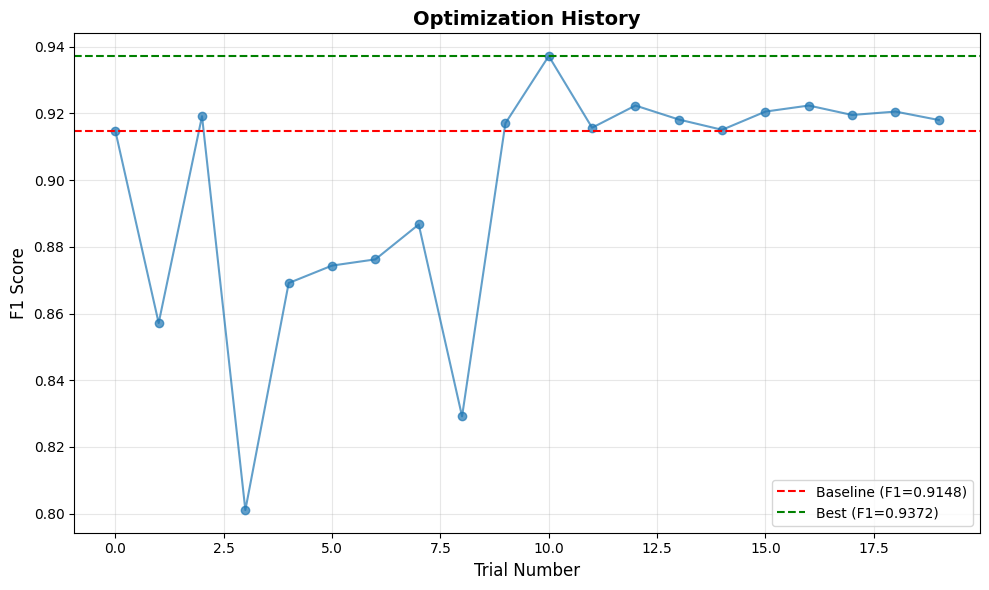

In [14]:
# Visualization Optimization History plot
fig = plt.figure(figsize=(10, 6))
# Plot 1: Optimization history
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials]

plt.plot(trial_numbers, trial_values, 'o-', alpha=0.7)
plt.axhline(y=baseline_trial.value, color='r', linestyle='--',
              label=f'Baseline (F1={baseline_trial.value:.4f})')
plt.axhline(y=study.best_trial.value, color='g', linestyle='--',
              label=f'Best (F1={study.best_trial.value:.4f})')
plt.xlabel('Trial Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Optimization History', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# We retrain the model with the best hyperparameters

best_params = study.best_trial.params
print("\nRetraining best model with optimal hyperparameters...")
print("\nHyperparameters used: ")
for key, value in best_params.items():
    print(f"    {key}: {value}")


best_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2,
                                                                hidden_dropout_prob=best_params["dropout"],
                                                                attention_probs_dropout_prob=best_params["dropout"]).to(device)

best_args = TrainingArguments(
    output_dir="./roberta_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    warmup_ratio=best_params["warmup_ratio"],
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none",
    seed=seed
)

final_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=train_dataset_tok, #We use the whole train dataset, not the stratified
    eval_dataset=dev_dataset_tok, #Dev for early stopping
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])

final_trainer.train()

eval_results = final_trainer.evaluate(test_dataset_tok)
print("\nFinal evaluation on test set:", eval_results)


Retraining best model with optimal hyperparameters...

Hyperparameters used: 
    learning_rate: 3.3535731125862e-05
    weight_decay: 0.10885871127380219
    batch_size: 16
    num_train_epochs: 4
    warmup_ratio: 0.002444416289117842
    dropout: 0.10580877999417745


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.475000,0.461911,0.815000,0.660550,1.000000,0.493151
2,0.238800,0.218966,0.925000,0.888889,0.967742,0.821918
3,0.152100,0.247517,0.920000,0.878788,0.983051,0.794521


In [ ]:
# Path Output
os.makedirs(f"{path}/experiments/text/HPO/", exist_ok=True)
output_dir = f"{path}/experiments/text/HPO/"

# Confusion Matrix
preds_output = final_trainer.predict(test_dataset_tok)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=-1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["oppose", "support"])

# Export
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title(f"Confusion Matrix_Optimized RoBERTa,f1_Score={eval_results['eval_f1']:.4f}")
save_path = os.path.join(output_dir,f"confusion_matrix_Model_Optimized.jpg")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()



In [20]:
# Export metrics to CSV
results_df = pd.DataFrame([eval_results]).rename(columns={
    "eval_accuracy": "accuracy",
    "eval_f1": "f1",
    "eval_precision": "precision",
    "eval_recall": "recall"
})

results_df = results_df[["accuracy", "f1", "precision", "recall"]]
results_df.to_csv(output_dir + "evaluation_results.csv", index=False)
print(f"Metrics saved to {output_dir}/evaluation_results.csv")
print(results_df)

ValueError: If using all scalar values, you must pass an index

In [ ]:
# Export best hyperparameters to JSON
best_hyperparams = study.best_trial.params
with open(f"{output_dir}/best_hyperparameters.json", "w") as f:
    json.dump(best_hyperparams, f, indent=4)
print(f"Best hyperparameters saved to {output_dir}/best_hyperparameters.json")
print(best_hyperparams)